In [1]:
# to handle  datasets
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

# to display all the columns/rows in the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/home/bazdalaz/.local/share/virtualenvs/730-ZrlwDO-V/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#hyperparameters
# DATASET='test'
DATASET='train'

HEATER = 'H161'
MAX_HEAD_PRESSURE = 400
MIN_HEAD_TEMPERATURE = 45
MIN_WEIGHT = 1400

In [3]:
# load the data
df = pd.read_csv('./data/' + DATASET + '/' +HEATER + '.csv', parse_dates=['utc_time'])
df.columns = ['time','batch','phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp']
df = df[df['phase'].str.contains('DRYING|HEATING|FEED|FEEDING') == True]

/tmp/ipykernel_5744/2712119367.py:2: DtypeWarning: Columns (1,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/' + DATASET + '/' +HEATER + '.csv', parse_dates=['utc_time'])


In [ ]:
# clean the data
df.replace({'??????': 0,'????????': 0, '???????': 0}, inplace=True)
df.dropna(inplace=True)

In [ ]:
#  type conversion
df['head_temp'] = df.head_temp.astype(float)
df['weight'] = df.weight.astype(float)
df['head_pressure'] = df.head_pressure.astype(float)
df['heat_time'] = df.heat_time.astype(float).astype(int)
df['vac_temp'] = df.vac_temp.astype(float)
df['batch'] = df.batch.astype(float).astype(int)
df['phase'] = df.phase.astype('category')

In [ ]:
#  label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['phase'] = le.fit_transform(df['phase'])

In [ ]:
# find local maximums
from scipy.signal import argrelextrema
n = 30 # number of points to be checked before and after

df['max_temp'] = 0
df['max_temp'] = df.iloc[argrelextrema(df.head_temp.values, np.greater_equal, order=n)]['head_temp']

In [ ]:
df['ready'] = 0
DELTA_TIME = 2  # time after max to be considered ready
DELTA_TEMP = 1  # temperature difference to be considered ready
df['ready'] = df.ready.astype(int)

for i in range(1, len(df) - 1):
    if df.max_temp.values[i] > 0:
        # and df.weight.values[i] > MIN_WEIGHT:
        # and df.head_temp.values[i] > MIN_HEAD_TEMPERATURE \
        # and df.head_pressure.values[i] < MAX_HEAD_PRESSURE \
        local_max = df.max_temp.values[i]
        current = df.batch.values[i]
        local_max_index = i
        while df['batch'].values[i] == current and i < len(df) - 1:
            if local_max - df.head_temp.values[i] > DELTA_TEMP and i > local_max_index + DELTA_TIME:
                df.ready.values[i] = 1
            i += 1

In [ ]:
df = df.drop(['max_temp'], axis=1)

In [ ]:
df['head_pressure_20'] = df['head_pressure'].shift(-20)
df['head_temp_20'] = df['head_temp'].shift(-20)
df['weight_20'] = df['weight'].shift(-20)
df['heat_time_20'] = df['heat_time'].shift(-20)
df['vac_temp_20'] = df['vac_temp'].shift(-20)
df['phase_20'] = df['phase'].shift(-20)

df['head_pressure_30'] = df['head_pressure'].shift(-30)
df['head_temp_30'] = df['head_temp'].shift(-30)
df['weight_30'] = df['weight'].shift(-30)
df['heat_time_30'] = df['heat_time'].shift(-30)
df['vac_temp_30'] = df['vac_temp'].shift(-30)
df['phase_30'] = df['phase'].shift(-30)

df['head_pressure_35'] = df['head_pressure'].shift(-35)
df['head_temp_35'] = df['head_temp'].shift(-35)
df['weight_35'] = df['weight'].shift(-35)
df['heat_time_35'] = df['heat_time'].shift(-35)
df['vac_temp_35'] = df['vac_temp'].shift(-35)
df['phase_35'] = df['phase'].shift(-35)

df['head_pressure_40'] = df['head_pressure'].shift(-40)
df['head_temp_40'] = df['head_temp'].shift(-40)
df['weight_40'] = df['weight'].shift(-40)
df['heat_time_40'] = df['heat_time'].shift(-40)
df['vac_temp_40'] = df['vac_temp'].shift(-40)
df['phase_40'] = df['phase'].shift(-40)
df.dropna(inplace=True)

In [ ]:
features = [
            'batch',
            'phase', 'heat_time','weight', 'head_temp', 'head_pressure', 'vac_temp',
            'phase_20','heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20',
            'phase_30','heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30',
            'phase_35','heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35',
            'phase_40','heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40'
            ]
label = ['ready']

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], shuffle = False)

# X_test.to_csv('./data/reference/' + HEATER + '/X_test.csv')
# y_test.to_csv('./data/reference/' + HEATER + '/y_test.csv')

In [ ]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            # gamma=0.25,
                            max_depth=8,
                            seed=42)

In [ ]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_train, y_train),(X_test, y_test)])

/home/bazdalaz/.local/share/virtualenvs/730-ZrlwDO-V/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bazdalaz/.local/share/virtualenvs/730-ZrlwDO-V/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.91803	validation_1-auc:0.89597
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.93093	validation_1-auc:0.90654
[2]	validation_0-auc:0.93595	validation_1-auc:0.91237
[3]	validation_0-auc:0.94113	validation_1-auc:0.92107
[4]	validation_0-auc:0.94550	validation_1-auc:0.92621
[5]	validation_0-auc:0.94797	validation_1-auc:0.92868
[6]	validation_0-auc:0.94962	validation_1-auc:0.92966
[7]	validation_0-auc:0.95159	validation_1-auc:0.92874
[8]	validation_0-auc:0.95349	validation_1-auc:0.92810
[9]	validation_0-auc:0.95505	validation_1-auc:0.92862
[10]	validation_0-auc:0.95668	validation_1-auc:0.92659
[11]	validation_0-auc:0.95895	validation_1-auc:0.92754
[12]	validation_0-auc:0.95989	validation_1-auc:0.92733
[13]	validation_0-auc:0.96123	validation_1-auc:0.92762
[14]	validation_0-auc:0.96185	validation_1-auc:0.92807
[15]	validation_0-auc:0.9623

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [ ]:
pred = clf_xgb.predict_proba(X_test)[:,1]
thr = 0.5

<AxesSubplot:>

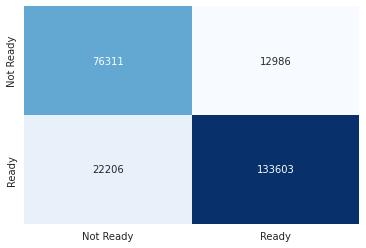

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test,pred>thr),annot=True,fmt='', cmap='Blues',cbar=False, xticklabels=['Not Ready','Ready'], yticklabels=['Not Ready','Ready'])


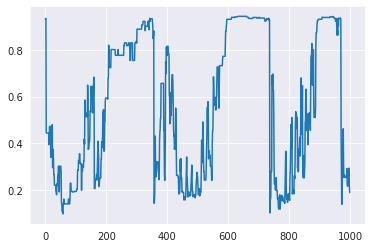

In [ ]:
plt.plot(pd.Series(pred[-1000:]))

In [ ]:
from sklearn.metrics import classification_report

print(HEATER,'DATASET=' + DATASET + '; MAX_HEAD_PRESSURE=' +  str(MAX_HEAD_PRESSURE) + '; MIN_HEAD_TEMPERATURE='+ str(MIN_HEAD_TEMPERATURE)+ '; MIN_WEIGHT=' + str(MIN_WEIGHT)+'; DELTA_TIME=' + str(DELTA_TIME)+'; DELTA_TEMP='+str(DELTA_TEMP),'Threshold= '+str(thr), 'features='+str(features),classification_report(y_test,pred>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test,pred>thr),y_test.value_counts(), sep='\n')


H161
DATASET=train; MAX_HEAD_PRESSURE=400; MIN_HEAD_TEMPERATURE=45; MIN_WEIGHT=1400; DELTA_TIME=2; DELTA_TEMP=1
Threshold= 0.5
features=['batch', 'phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp', 'phase_20', 'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20', 'phase_30', 'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30', 'phase_35', 'heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35', 'phase_40', 'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40']
              precision    recall  f1-score   support

   Not Ready       0.77      0.85      0.81     89297
       Ready       0.91      0.86      0.88    155809

    accuracy                           0.86    245106
   macro avg       0.84      0.86      0.85    245106
weighted avg       0.86      0.86      0.86    245106

[[ 76311  12986]
 [ 22206 133603]]
ready
1        155809
0         89297
dtype: int64

In [ ]:
X_test_61 = pd.read_csv('./data/reference/H161/X_test.csv')
y_test_61 = pd.read_csv('./data/reference/H161/y_test.csv')
X_test_61.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test_61.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
print(HEATER, 'threshold='+str(thr))
print(classification_report(y_test_61, clf_xgb.predict_proba(X_test_61)[:,1]>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test_61, clf_xgb.predict_proba(X_test_61)[:,1]>thr),y_test_61.value_counts(), sep='\n')

H161 threshold=0.5


ValueError: feature_names mismatch: ['batch', 'phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp', 'phase_20', 'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20', 'phase_30', 'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30', 'phase_35', 'heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35', 'phase_40', 'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40'] ['batch', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp', 'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20', 'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30', 'heat_time_35', 'weight_35', 'head_temp_35', 'head_pressure_35', 'vac_temp_35', 'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40']
expected phase_40, phase_20, phase_35, phase, phase_30 in input data

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plti

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
plti.plot(fpr, tpr)
plti.xlabel('False Positive Rate')
plti.ylabel('True Positive Rate')
plti.title('ROC Curve')
plti.show()